In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the Libraries

In [4]:
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns


#Tensorflow for Multipplex Layer

import tensorflow
from keras.models import Sequential
from keras.layers import Dense

from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA


confirmed_df = pd.read_csv('/content/drive/MyDrive/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('/content/drive/MyDrive/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('/content/drive/MyDrive/time_series_covid19_recovered_global.csv')




Description of Dataset Used

In [5]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,48229,48527,48718,48952,49161,49378,49621,49681,49817,50013,50190,50433,50655,50810,50886,51039,51280,51350,51405,51526,51526,51526,51526,53011,53105,53105,53207,53332,53400,53489,53538,53584,53584,53775,53831,53938,53984,54062,54141,54278
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,47742,48530,49191,50000,50637,51424,52004,52542,53003,53425,53814,54317,54827,55380,55755,56254,56572,57146,57727,58316,58316,58991,59438,59623,60283,61008,61705,62378,63033,63595,63971,64627,65334,65994,66635,67216,67690,67982,68568,69238
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,91638,92102,92597,93065,93507,93933,94371,94781,95203,95659,96069,96549,97007,97441,97857,98249,98631,98988,99311,99610,99897,100159,100408,100645,100873,101120,101382,101657,101913,102144,102369,102641,102860,103127,103381,103611,103833,104092,104341,104606
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7288,7338,7382,7382,7446,7466,7519,7560,7577,7602,7633,7669,7699,7756,7806,7821,7875,7919,7983,8049,8117,8166,8192,8249,8308,8348,8348,8489,8586,8586,8586,8682,8818,8868,8946,9038,9083,9083,9194,9308
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,16161,16188,16277,16362,16407,16484,16562,16626,16644,16686,16802,16931,17029,17099,17149,17240,17296,17371,17433,17553,17568,17608,17642,17684,17756,17864,17974,18066,18156,18193,18254,18343,18425,18613,18679,18765,18875,18926,19011,19093


In [6]:
deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1956,1965,1969,1995,2011,2025,2030,2047,2067,2082,2096,2117,2126,2139,2149,2160,2174,2179,2181,2191,2191,2191,2191,2237,2244,2244,2253,2257,2264,2277,2288,2301,2301,2314,2324,2336,2339,2343,2346,2354
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,989,1003,1016,1028,1040,1055,1066,1074,1088,1098,1111,1117,1125,1134,1143,1153,1164,1170,1174,1181,1181,1190,1193,1199,1210,1217,1223,1230,1233,1241,1247,1252,1256,1261,1265,1270,1277,1281,1287,1291
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2584,2596,2609,2623,2631,2640,2647,2659,2666,2675,2687,2696,2705,2716,2722,2728,2737,2745,2751,2756,2762,2769,2772,2777,2782,2786,2792,2798,2803,2807,2812,2816,2819,2822,2827,2831,2836,2840,2843,2849
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,78,79,79,79,79,79,80,80,81,81,82,82,83,83,83,83,83,84,84,84,84,84,84,84,84,84,84,84,85,85,85,86,87,88,88,91,91,91,92,92
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,366,371,372,372,379,382,384,386,387,390,393,393,393,396,399,399,403,403,405,405,405,407,408,408,410,413,413,415,416,416,420,422,424,425,428,431,436,439,442,444


In [7]:
recovered_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,38200,38250,38252,38336,38475,38505,38540,38613,39006,39508,39585,39692,40359,40444,40784,41096,41441,41543,41612,41727,41727,41727,41727,42530,42666,42666,43291,43440,43740,43948,44137,44608,44850,45298,45434,45465,45868,46359,46554,46759
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,24520,24820,24820,25876,26381,26898,27426,27831,28121,28752,29249,29799,30276,30790,31181,31565,32122,32700,33185,33634,33634,34353,34648,34996,35551,36102,36535,36971,37327,37648,37981,38421,38860,39246,39625,40090,40453,40870,41464,41969
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,60028,60457,60888,61307,61700,62089,62487,62869,63260,63644,64020,64401,64777,65144,65505,65862,66214,66550,66855,67127,67395,67611,67808,67999,68185,68383,68589,68802,69011,69212,69403,69608,69791,69992,70188,70373,70554,70747,70933,71127
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6629,6629,6706,6706,6819,6875,6919,6963,6997,7028,7073,7106,7171,7203,7252,7288,7318,7360,7384,7432,7463,7463,7517,7548,7585,7615,7615,7724,7724,7724,7724,7930,8070,8091,8116,8116,8154,8154,8349,8399
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,8841,8898,8924,8990,9194,9266,9345,9518,9592,9695,9729,9729,9729,9921,9976,10354,10354,10627,10859,11044,11146,11189,11223,11266,11376,11477,11955,12712,13205,13872,14825,15512,15631,16008,16120,16225,16347,16677,16822,16921


In [9]:
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

Comparision with other countries

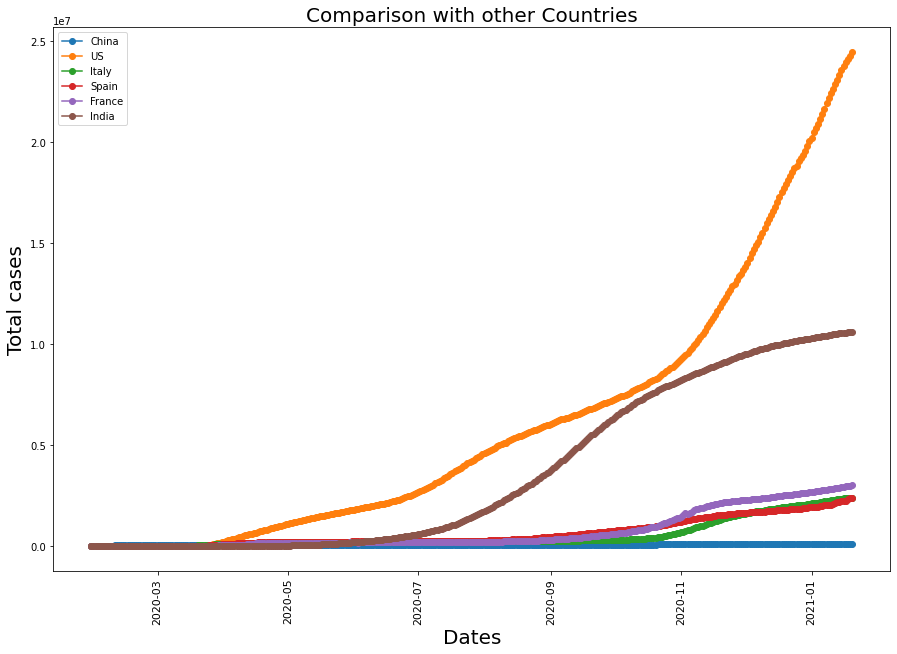

In [10]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

countries = ['China','US', 'Italy', 'Spain', 'France','India']

global_confirmed = []
global_recovered = []
global_deaths = []
global_active = []

for country in countries:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed.append(k.values.tolist()[0]) 

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0]) 

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0])  

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Comparison with other Countries" , fontsize = 20)

for i in range(len(countries)):
    plt.plot_date(y= global_confirmed[i],x= dates_india,label = countries[i],linestyle ='-')
plt.legend();

In [11]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [12]:
train['day'] = train['Date'].dt.day
train['month'] = train['Date'].dt.month
train['dayofweek'] = train['Date'].dt.dayofweek
train['dayofyear'] = train['Date'].dt.dayofyear
train['quarter'] = train['Date'].dt.quarter
train['weekofyear'] = train['Date'].dt.weekofyear
test['day'] = test['Date'].dt.day
test['month'] = test['Date'].dt.month
test['dayofweek'] = test['Date'].dt.dayofweek
test['dayofyear'] = test['Date'].dt.dayofyear
test['quarter'] = test['Date'].dt.quarter
test['weekofyear'] = test['Date'].dt.weekofyear
countries = list(train['Country_Region'].unique())
india_code = countries.index('India')
train = train.drop(['Date','Id'],1)
test =  test.drop(['Date'],1)

train.Province_State.fillna('NaN', inplace=True)
oe = OrdinalEncoder()
train[['Province_State','Country_Region']] = oe.fit_transform(train.loc[:,['Province_State','Country_Region']])

test.Province_State.fillna('NaN', inplace=True)
oe = OrdinalEncoder()
test[['Province_State','Country_Region']] = oe.fit_transform(test.loc[:,['Province_State','Country_Region']])

In [13]:
columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State', 'Country_Region','ConfirmedCases','Fatalities']
test_columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State','Country_Region']
train = train[columns]
x = train.drop(['Fatalities','ConfirmedCases'], 1)
y = train['ConfirmedCases']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
test = test[test_columns]
test_india = test[test['Country_Region'] == india_code]

LGBM Regression

In [14]:
lgbm = LGBMRegressor(n_estimators=1300)
lgbm.fit(x_train,y_train)
pred = lgbm.predict(x_test)
lgbm_forecast = lgbm.predict(test_india)
mse=(round(mean_squared_error(pred, y_test),2))
mae=(round(mean_absolute_error(pred, y_test),2))
rmse=(round(np.sqrt(mean_squared_error(pred, y_test)),2))
print(mse)
print(mae)
print(rmse)

1777777.79
441.5
1333.33


Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
LR_forecast = clf.predict(test_india)
mse=(round(mean_squared_error(pred, y_test),2))
mae=(round(mean_absolute_error(pred, y_test),2))
rmse=(round(np.sqrt(mean_squared_error(pred, y_test)),2))
print(mse)
print(mae)
print(rmse)

317892450.02
3415.65
17829.54


Lasso Regression

In [15]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
lasso_forecast = clf.predict(test_india)
mse=(round(mean_squared_error(pred, y_test),2))
mae=(round(mean_absolute_error(pred, y_test),2))
rmse=(round(np.sqrt(mean_squared_error(pred, y_test)),2))
print(mse)
print(mae)
print(rmse)

290738263.65
5835.93
17051.05


Tensorflow with Multiplex Layer

In [16]:
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model.fit(x_train,y_train, epochs=5, batch_size=10)

Epoch 1/5
2880/2880 [==============================] - 17s 1ms/step - loss: -27756708.0231 - accuracy: 0.0710
Epoch 2/5
2880/2880 [==============================] - 4s 1ms/step - loss: -739672748.1958 - accuracy: 0.0286
Epoch 3/5
2880/2880 [==============================] - 4s 1ms/step - loss: -2860775937.8549 - accuracy: 0.0307
Epoch 4/5
2880/2880 [==============================] - 3s 1ms/step - loss: -7281077931.6737 - accuracy: 0.0310
Epoch 5/5
2880/2880 [==============================] - 4s 1ms/step - loss: -13778880646.1756 - accuracy: 0.0315


In [18]:
_, accuracy = model.evaluate(x_train,y_train)
print('Accuracy: %.2f' % ((accuracy*30)*100))

900/900 [==============================] - 2s 1ms/step - loss: -20436287488.0000 - accuracy: 0.0309
Accuracy: 92.72


In [27]:
pred = model.predict(x_test)

In [28]:
mse=(round(mean_squared_error(pred, y_test),2))
mae=(round(mean_absolute_error(pred, y_test),2))
rmse=(round(np.sqrt(mean_squared_error(pred, y_test)),2))
print(mse)
print(mae)
print(rmse)

317003361.1
3403.89
17804.59


In [21]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
k = df1[df1['Country/Region']=='India'].loc[:,'1/22/20':]
india_confirmed = k.values.tolist()[0] 
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = dates
data['y'] = india_confirmed


Predicting up to march of 2021

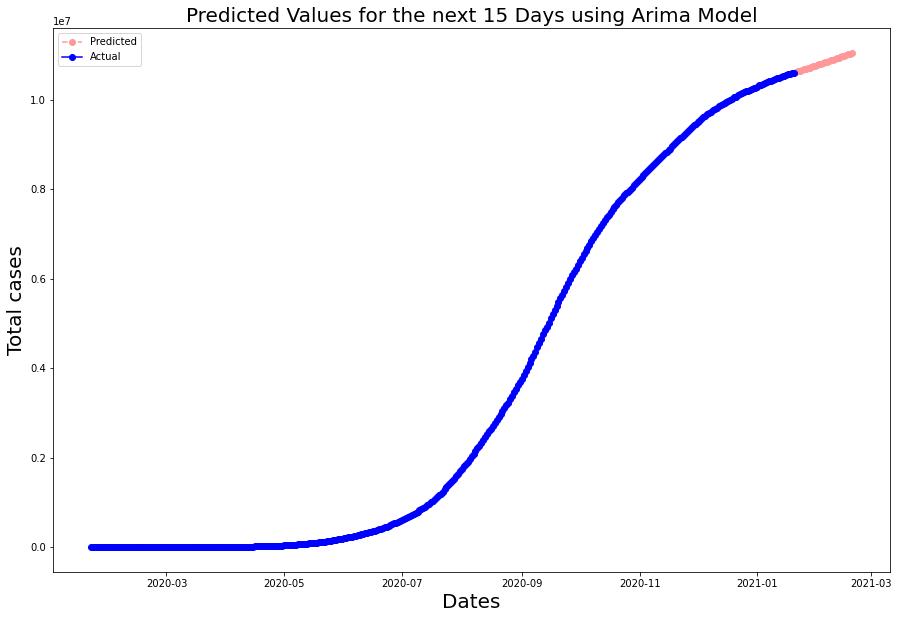

In [22]:
arima = ARIMA(data['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)
forecast = arima.forecast(steps= 30)
pred = list(forecast[0])

start_date = data['ds'].max()
prediction_dates = []
for i in range(30):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days using Arima Model" , fontsize = 20)

plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
plt.plot_date(y=data['y'],x=data['ds'],linestyle = '-',color = 'blue',label = 'Actual');
plt.legend();

Predicting upto may of 2021

In [23]:
confirmed_df1 = pd.read_csv('/content/drive/MyDrive/time_series_covid_19_confirmed.csv')
deaths_df = pd.read_csv('/content/drive/MyDrive/time_series_covid_19_deaths.csv')
recovered_df = pd.read_csv('/content/drive/MyDrive/time_series_covid_19_recovered.csv')

df = confirmed_df1.groupby('Country/Region').sum().reset_index()
k = df[df['Country/Region']=='India'].loc[:,'1/22/20':]
india_confirmed = k.values.tolist()[0] 
dates = list(confirmed_df1.columns[4:])
dates = list(pd.to_datetime(dates))
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = dates
data['y'] = india_confirmed

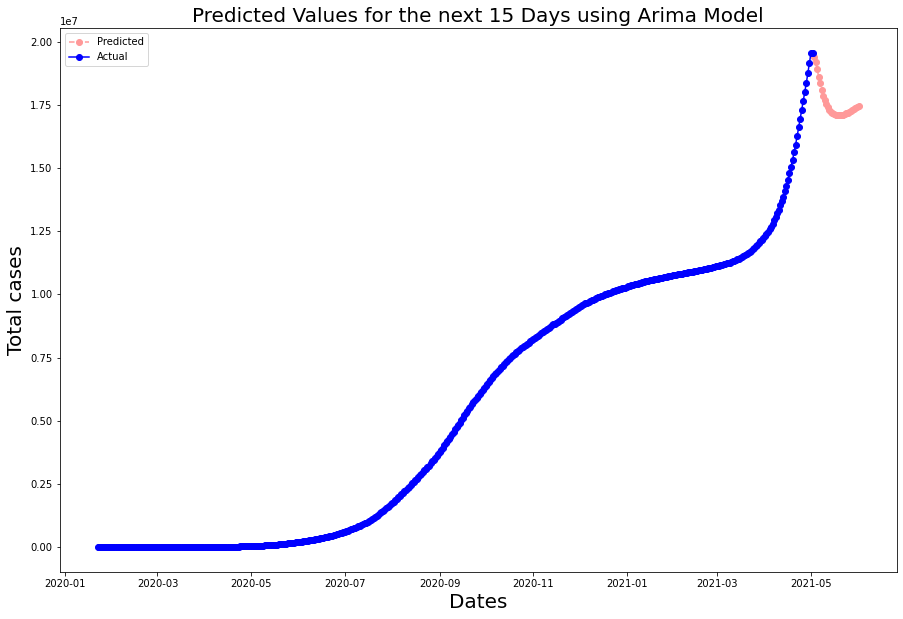

In [24]:
arima = ARIMA(data['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)
forecast = arima.forecast(steps= 30)
pred = list(forecast[0])

start_date = data['ds'].max()
prediction_dates = []
for i in range(30):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days using Arima Model" , fontsize = 20)

plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
plt.plot_date(y=data['y'],x=data['ds'],linestyle = '-',color = 'blue',label = 'Actual');
plt.legend();